## Battle of the Neighborhoods: NYC Beach Neighborhoods

## Introduction

Recently, there has been a massive influx of young people moving to and working in NYC, NY. We represent a large real estate firm for young professionals. A new client would like to move to a neighborhood in NYC that has access to beaches and yogo studios, as well as restaurants. Price range is not a limitation. The purpose of this project is to help this young professional determine which neighborhoods they should live in that has access to beaches and yogo studios and restaurants.

## The Problem

The major purpose of this project is to provide a list of potential neighborhoods in NYC, NY for our client that matches her needs. We will use this data to suggest a neighborhood for her to move into and buy real estate.

## We Will Need

For this project we need the following data:

- New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
- Venues in each neighborhood of NYC, especially beaches, yoga studios, and restaurants
- GeoSpace data

## The Location

New York City is a bustling metropolis that spans 5 boroughs in the State of New York. While it is known for it's nonstop nightlife, it also has many recreational studios, beaches, parks, and markets. 

## Foursquare API

This project would use Four-square API as its prime data gathering source as it has a database of millions of places, especially their places API which provides the ability to perform location search, location sharing and details about a business.

## Work Flow

We begin by collecting the New York city data from a json file from the IBM course at "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json"
We will find all venues for each neighborhood using FourSquare API.
We will sort types of venues by neighborhood.
We will use k-means clustering to visualize clusters of neighborhoods by venue category patteners.
Based on the clustering patterns, we will make recommendations of neighborhoods to our client. 

## Clustering Approach

To make recommendations on where to live, we explored, segmented, and clustered the top types of venues within neighborhoods to make recommendations. To be able to do that, we need to cluster data which is a form of unsupervised machine learning: k-means clustering algorithm.

## Libraries Used to Develop Project

Pandas: For creating and manipulating dataframes. Folium: Python visualization library would be used to visualize the neighborhoods cluster distribution of using interactive leaflet map. Scikit Learn: For importing k-means clustering. JSON: Library to handle JSON files. XML: To separate data from presentation and XML stores data in plain text format. Geocoder: To retrieve Location Data. Beautiful Soup and Requests: To scrap and library to handle http requests. Matplotlib: Python Plotting Module.

## Table of Contents

#### 01- Import Libraries
#### 02- Define Foursquare Credentials
#### 03- Define the city and get its latitude & longitude
#### 04- Search for venues & clean dataframe
#### 05- Generate map to visualize clusters of venues per neighborhood
#### 06- Conclusions

## Set up environment & libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip3 install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip3 install folium
import folium # map rendering library

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


## Download and explore NYC dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
# load the data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

## Transform data into dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
# loop through the data and fill the dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [9]:
#  Clean NA cells and cells whose `Borough` is `Not assigned`
neighborhoods = neighborhoods.dropna()
neighborhoods = neighborhoods[neighborhoods['Borough'] != 'Not assigned']

# If a cell has a borough but a Not assigned neighborhood, 
# then the neighborhood will be the same as the borough.
not_assigned_ids = neighborhoods['Neighborhood'] == 'Not assigned'
neighborhoods['Neighborhood'][not_assigned_ids] = neighborhoods['Borough'][not_assigned_ids]

# Replace '/' by ','
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].str.replace(' /', ',')
neighborhoods.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

## Use geopy library to get the latitude and longitude values of New York City

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

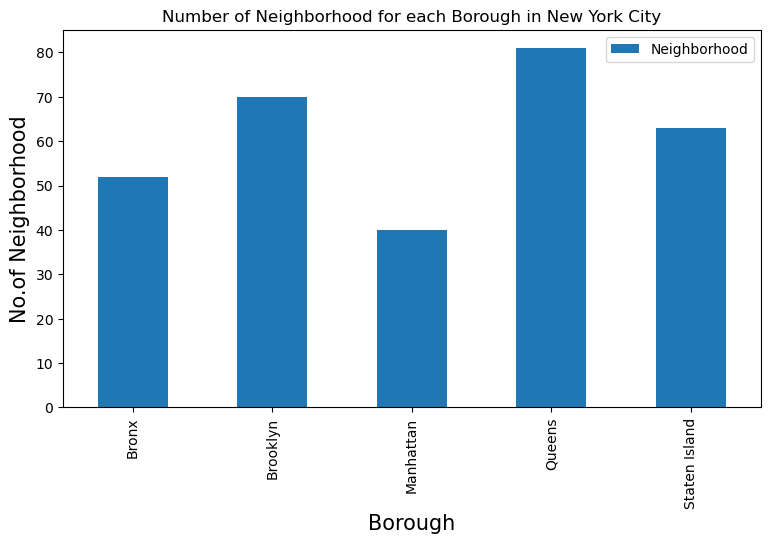

In [12]:
# create bar plot to visualize neighborhoods per borough
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Set up Foursquare credentials and endpoint

In [13]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID:0U32RZTGM030EKRS4L0IJDSATQKFVOFNVFT5VGNHS53UIN5R
CLIENT_SECRET:KHHFJGP5KP13AGI5ZMKIDMKYY2MT4ES5JLSI1Z10BKXQ1AEI


In [14]:
# set endpoint parameters
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=0U32RZTGM030EKRS4L0IJDSATQKFVOFNVFT5VGNHS53UIN5R&client_secret=KHHFJGP5KP13AGI5ZMKIDMKYY2MT4ES5JLSI1Z10BKXQ1AEI&v=20180605&ll=40.7127281,-74.0060152&radius=500&limit=100'

In [15]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60a5636425c9092a2fd5aec2'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Downtown Manhattan',
  'headerFullLocation': 'Downtown Manhattan, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 111,
  'suggestedBounds': {'ne': {'lat': 40.7172281045, 'lng': -74.00008952063419},
   'sw': {'lat': 40.7082280955, 'lng': -74.0119408793658}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57f0689d498e7d49d9189369',
       'name': 'The Bar Room at Temple Court',
       'location': {'address': '123 Nassau St',
        'lat': 40.7114477287544,
        'lng': -74.00680157032005,
        'labe

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
# lean the json and structure it into a pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


name       categories        lat        lng
0   The Bar Room at Temple Court        Hotel Bar  40.711448 -74.006802
1  The Beekman, A Thompson Hotel            Hotel  40.711173 -74.006702
2      Alba Dry Cleaner & Tailor  Laundry Service  40.711434 -74.006272
3                 City Hall Park             Park  40.712359 -74.007493
4   Gibney Dance Center Downtown     Dance Studio  40.713923 -74.005661

In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
# Get number of restaurants in NYC
NYC_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [21]:
print(NYC_venues.shape)
NYC_venues.head()

(10032, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3         Walgreens       40.896528       -73.844700        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

In [22]:
NYC_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Allerton                                      30                      30   
Annadale                                      11                      11   
Arden Heights                                  7                       7   
Arlington                                      5                       5   
Arrochar                                      23                      23   
Arverne                                       21                      21   
Astoria                                      100                     100   
Astoria Heights                               13                      13   
Auburndale                                    20                      20   
Bath Beach                                    46                      46   
Battery Park City                             82                      82   
Bay Ridge                                     79                      79   
Bay Terrace                                   48                      48   
Baychester                                    22                      22   
Bayside                                       74                      74   
Bayswater                                      1                       1   
Bedford Park                                  39                      39   
Bedford Stuyvesant                            33                      33   
Beechhurst                                    18                      18   
Bellaire                                      13                      13   
Belle Harbor                                  17                      17   
Bellerose                                     20                      20   
Belmont                                      100                     100   
Bensonhurst                                   28                      28   
Bergen Beach                                   7                       7   
Blissville                                    18                      18   
Bloomfield                                     4                       4   
Boerum Hill                                   88                      88   
Borough Park                                  18                      18   
Breezy Point                                   6                       6   
Briarwood                                     10                      10   
Brighton Beach                                43                      43   
Broad Channel                                  5                       5   
Broadway Junction                             15                      15   
Bronxdale                                     12                      12   
Brooklyn Heights                             100                     100   
Brookville                                     3                       3   
Brownsville                                   15                      15   
Bulls Head                                    42                      42   
Bushwick                                      67                      67   
Butler Manor                                   6                       6   
Cambria Heights                               15                      15   
Canarsie                                       6                       6   
Carnegie Hill                                 93                      93   
Carroll Gardens                              100                     100   
Castle Hill                                    7                       7   
Castleton Corners                             15                      15   
Central Harlem                                45                      45   
Charleston                                    26                      26   
Chelsea                                      104                     104   
Chinatown                                    100                     100   

In [23]:
print('There are {} uniques categories.'.format(len(NYC_venues['Venue Category'].unique())))

There are 430 uniques categories.


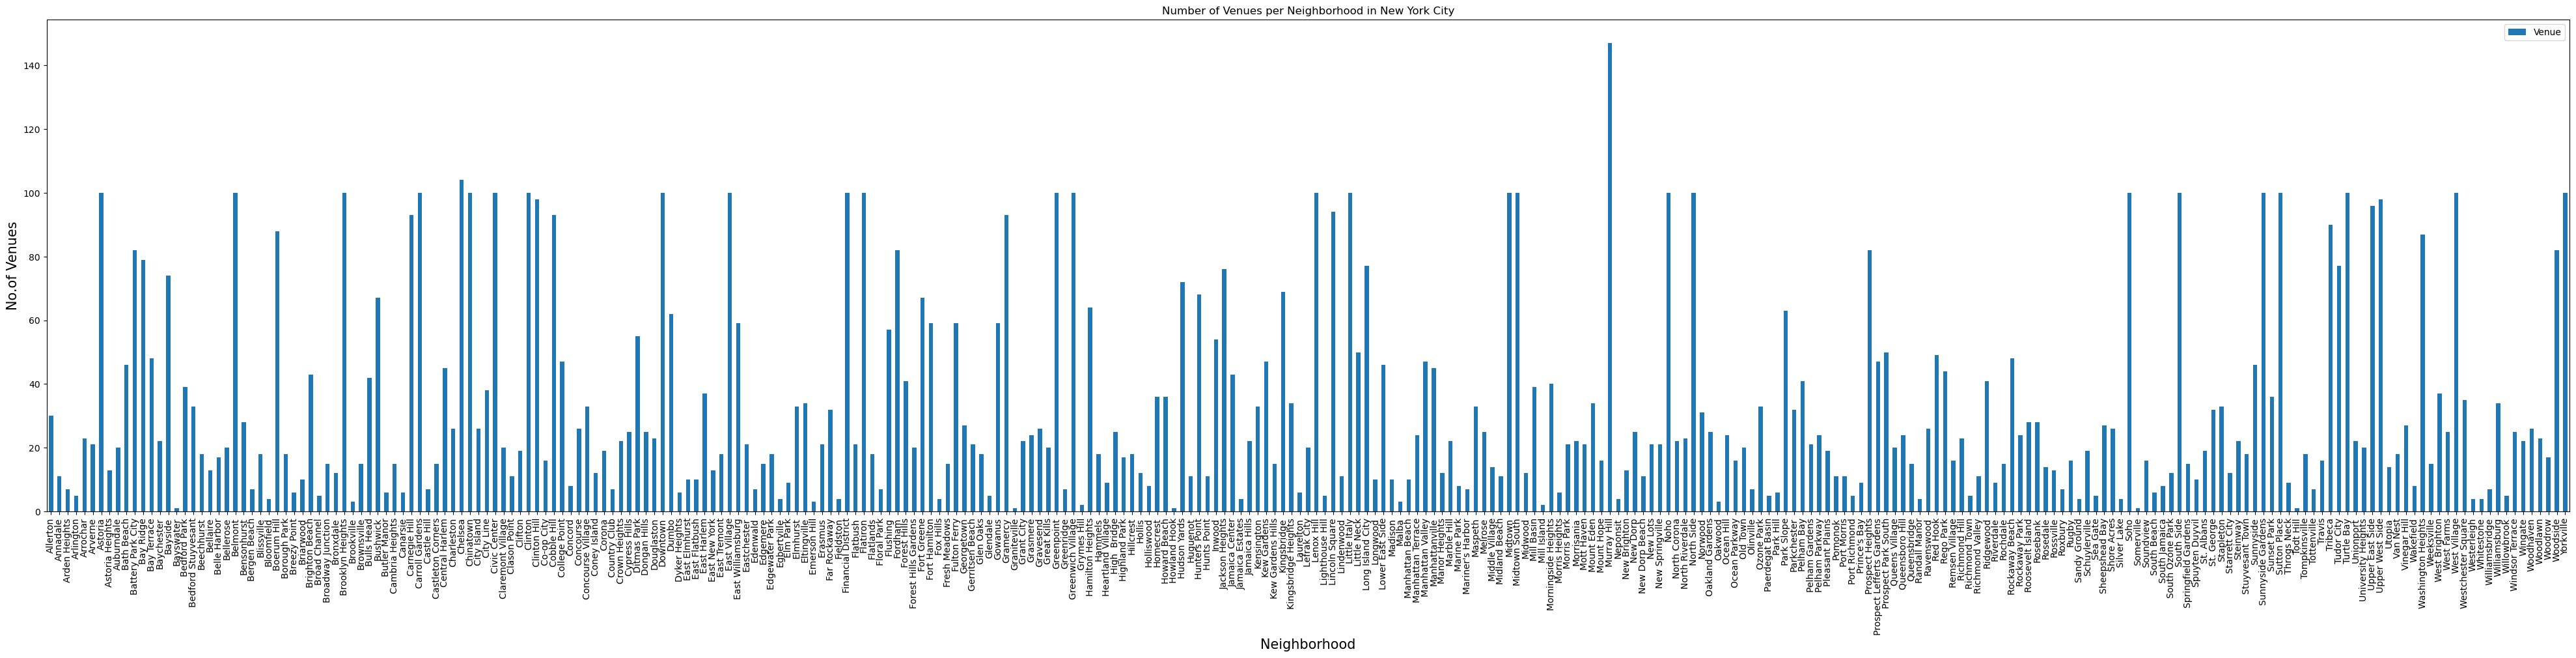

In [43]:
# create bar plot to visualize number of venues per neighborhood
plt.figure(figsize=(50,10), dpi = 100)
# title
plt.title('Number of Venues per Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Venues', fontsize=15)
#giving a bar plot
NYC_venues.groupby('Neighborhood')['Venue'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

## Analyze each neighborhood

In [24]:
# one hot encoding
NYC_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NYC_onehot['Neighborhood'] = NYC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
manhattan_onehot = NYC_onehot[fixed_columns]

NYC_onehot.head()

Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                  0               0                  0                   0   
1                  0               0                  0                   0   
2                  0               0                  0                   0   
3                  0               0                  0                   0   
4                  0               0                  0                   0   

   Airport Terminal  American Restaurant  Antique Shop  Arcade  \
0                 0                    0             0       0   
1                 0                    0             0       0   
2                 0                    0             0       0   
3                 0                    0             0       0   
4                 0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                0                0          0           0           0   
1                0                0          0           0           0   
2                0                0          0           0           0   
3                0                0          0           0           0   
4                0                0          0           0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     0    0               0                 0                 0   
2       0     0    0               0                 0                 0   
3       0     0    0               0                 0                 0   
4       0     0    0               0                 0                 0   

   Bath House  Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0           0      0          0         0            0           0   
1           0      0          0         0            0           0   
2           0      0          0         0            0           0   
3           0      0          0         0            0           0   
4           0      0          0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0          0           0       0   

   Board Shop  Boat or Ferry

In [25]:
NYC_onehot.shape

(10032, 430)

In [26]:
NYC_grouped = NYC_onehot.groupby('Neighborhood').mean().reset_index()
NYC_grouped

Neighborhood  Accessories Store  Adult Boutique  \
0                     Allerton           0.000000        0.000000   
1                     Annadale           0.000000        0.000000   
2                Arden Heights           0.000000        0.000000   
3                    Arlington           0.000000        0.000000   
4                     Arrochar           0.000000        0.000000   
5                      Arverne           0.000000        0.000000   
6                      Astoria           0.000000        0.000000   
7              Astoria Heights           0.000000        0.000000   
8                   Auburndale           0.000000        0.000000   
9                   Bath Beach           0.000000        0.000000   
10           Battery Park City           0.000000        0.000000   
11                   Bay Ridge           0.000000        0.000000   
12                 Bay Terrace           0.000000        0.000000   
13                  Baychester           0.000000        0.000000   
14                     Bayside           0.000000        0.000000   
15                   Bayswater           0.000000        0.000000   
16                Bedford Park           0.000000        0.000000   
17          Bedford Stuyvesant           0.000000        0.000000   
18                  Beechhurst           0.000000        0.000000   
19                    Bellaire           0.000000        0.000000   
20                Belle Harbor           0.000000        0.000000   
21                   Bellerose           0.000000        0.000000   
22                     Belmont           0.000000        0.000000   
23                 Bensonhurst           0.000000        0.000000   
24                Bergen Beach           0.000000        0.000000   
25                  Blissville           0.000000        0.000000   
26                  Bloomfield           0.000000        0.000000   
27                 Boerum Hill           0.000000        0.000000   
28                Borough Park           0.000000        0.000000   
29                Breezy Point           0.000000        0.000000   
30                   Briarwood           0.000000        0.000000   
31              Brighton Beach           0.000000        0.000000   
32               Broad Channel           0.000000        0.000000   
33           Broadway Junction           0.000000        0.000000   
34                   Bronxdale           0.000000        0.000000   
35            Brooklyn Heights           0.000000        0.000000   
36                  Brookville           0.000000        0.000000   
37                 Brownsville           0.000000        0.000000   
38                  Bulls Head           0.000000        0.000000   
39                    Bushwick           0.000000        0.000000   
40                Butler Manor           0.000000        0.000000   
41             Cambria Heights           0.000000        0.000000   
42                    Canarsie           0.000000        0.000000   
43               Carnegie Hill           0.000000        0.000000   
44             Carroll Gardens           0.000000        0.000000   
45                 Castle Hill           0.000000        0.000000   
46           Castleton Corners           0.000000        0.000000   
47              Central Harlem           0.000000        0.000000   
48                  Charleston           0.000000        0.000000   
49                     Chelsea           0.000000        0.000000   
50                   Chinatown           0.000000        0.000000   
51                 City Island           0.000000        0.000000   
52                   City Line           0.000000        0.000000   
53                Civic Center           0.000000        0.000000   
54           Claremont Village           0.000000        0.000000   
55                Clason Point           0.000000        0.000000   
56                     Clifton           0.000000        0.000000   
57              

In [27]:
NYC_grouped.shape

(301, 430)

In [28]:
num_top_venues = 5

for hood in NYC_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NYC_grouped[NYC_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
            venue  freq
0     Pizza Place  0.13
1  Discount Store  0.07
2     Supermarket  0.07
3        Pharmacy  0.07
4   Deli / Bodega  0.07


----Annadale----
            venue  freq
0     Pizza Place  0.18
1      Restaurant  0.09
2  Cosmetics Shop  0.09
3        Pharmacy  0.09
4             Bar  0.09


----Arden Heights----
                 venue  freq
0        Deli / Bodega  0.14
1          Coffee Shop  0.14
2          Pizza Place  0.14
3  Rental Car Location  0.14
4             Bus Stop  0.14


----Arlington----
                 venue  freq
0        Deli / Bodega   0.2
1  American Restaurant   0.2
2        Grocery Store   0.2
3         Intersection   0.2
4          Coffee Shop   0.2


----Arrochar----
                venue  freq
0            Bus Stop  0.17
1       Deli / Bodega  0.09
2         Pizza Place  0.09
3  Italian Restaurant  0.09
4  Athletics & Sports  0.04


----Arverne----
            venue  freq
0       Surf Spot  0.19
1  Sandwich Place  0.10
2   Met

In [29]:
# put into pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
# create new dataframe
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NYC_grouped['Neighborhood']

for ind in np.arange(NYC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NYC_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale           Pizza Place            Restaurant   
2  Arden Heights   Rental Car Location         Deli / Bodega   
3      Arlington         Grocery Store         Deli / Bodega   
4       Arrochar              Bus Stop    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue      5th Most Common Venue  \
0           Supermarket        Discount Store                   Pharmacy   
1         Train Station                Bakery             Cosmetics Shop   
2           Coffee Shop              Bus Stop                Pizza Place   
3           Coffee Shop   American Restaurant               Intersection   
4           Pizza Place         Deli / Bodega  Middle Eastern Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Department Store    Chinese Restaurant   Martial Arts School   
1                   Pub                   Bar   American Restaurant   
2                Lawyer              Pharmacy     Fish & Chips Shop   
3           Yoga Studio               Factory    Falafel Restaurant   
4           Supermarket        Sandwich Place          Liquor Store   

  9th Most Common Venue 10th Most Common Venue  
0                Bakery            Bus Station  
1                 Diner               Pharmacy  
2            Eye Doctor                Factory  
3                  Farm         Farmers Market  
4     Polish Restaurant         Cosmetics Shop

## Clustering

In [31]:
# set number of clusters
kclusters = 5

NYC_grouped_clustering = NYC_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NYC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


# merge NYC_grouped with neighborhoods to add latitude/longitude for each neighborhood
NYC_merged = neighborhoods.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NYC_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             2.0   
1   Bronx   Co-op City  40.874294 -73.829939             2.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             2.0   
4   Bronx    Riverdale  40.890834 -73.912585             2.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy            Donut Shop         Deli / Bodega   
1     Accessories Store            Bagel Shop                Market   
2           Bus Station  Caribbean Restaurant         Deli / Bodega   
3                 River           Bus Station           Music Venue   
4           Bus Station                  Park        Baseball Field   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Sandwich Place          Dessert Shop        Ice Cream Shop   
1         Grocery Store                  Park  Fast Food Restaurant   
2                 Diner              Bus Stop            Donut Shop   
3                 Plaza           Yoga Studio           Flea Market   
4                  Bank            Food Truck                 Plaza   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Laundromat   Filipino Restaurant           Fish Market   
1              Pharmacy           Pizza Place            Donut Shop   
2              Platform     Food & Drink Shop    Seafood Restaurant   
3               Factory    Falafel Restaurant                  Farm   
4                   Gym           Fish Market               Factory   

  10th Most Common Venue  
0      Fish & Chips Shop  
1            Post Office  
2          Bowling Alley  
3         Farmers Market  
4     Falafel Restaurant

In [33]:
#  Clean NA cells
NYC_merged = NYC_merged.dropna()
NYC_merged.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             2.0   
1   Bronx   Co-op City  40.874294 -73.829939             2.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             2.0   
4   Bronx    Riverdale  40.890834 -73.912585             2.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy            Donut Shop         Deli / Bodega   
1     Accessories Store            Bagel Shop                Market   
2           Bus Station  Caribbean Restaurant         Deli / Bodega   
3                 River           Bus Station           Music Venue   
4           Bus Station                  Park        Baseball Field   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Sandwich Place          Dessert Shop        Ice Cream Shop   
1         Grocery Store                  Park  Fast Food Restaurant   
2                 Diner              Bus Stop            Donut Shop   
3                 Plaza           Yoga Studio           Flea Market   
4                  Bank            Food Truck                 Plaza   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Laundromat   Filipino Restaurant           Fish Market   
1              Pharmacy           Pizza Place            Donut Shop   
2              Platform     Food & Drink Shop    Seafood Restaurant   
3               Factory    Falafel Restaurant                  Farm   
4                   Gym           Fish Market               Factory   

  10th Most Common Venue  
0      Fish & Chips Shop  
1            Post Office  
2          Bowling Alley  
3         Farmers Market  
4     Falafel Restaurant

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYC_merged['Latitude'], NYC_merged['Longitude'], NYC_merged['Neighborhood'], NYC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + 'Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [35]:
# cluster 1
NYC_merged.loc[NYC_merged['Cluster Labels'] == 0, NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
85        Sea Gate           Bus Station                 Beach   
172   Breezy Point                 Beach           Supermarket   
179       Neponsit                 Beach           Yoga Studio   
204    South Beach                  Pier         Deli / Bodega   
232  Midland Beach                 Beach      Basketball Court   
288        Roxbury        Baseball Field         Deli / Bodega   
302        Hammels                 Beach              Building   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
85    American Restaurant                   Spa           Video Store   
172                 Trail              Bus Stop   Monument / Landmark   
179           Flower Shop               Factory    Falafel Restaurant   
204                 Beach            Theme Park    Athletics & Sports   
232            Restaurant             Bookstore    Russian Restaurant   
288                 Beach                 Trail             Irish Pub   
302                 Diner               Dog Run            Shoe Store   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
85            Yoga Studio           Flea Market               Factory   
172           Yoga Studio           Flea Market    Falafel Restaurant   
179                  Farm        Farmers Market  Fast Food Restaurant   
204           Yoga Studio           Flea Market    Falafel Restaurant   
232    Chinese Restaurant   Sporting Goods Shop          Liquor Store   
288  Fast Food Restaurant           Flea Market            Eye Doctor   
302  Fast Food Restaurant            Food Truck   Fried Chicken Joint   

    9th Most Common Venue 10th Most Common Venue  
85     Falafel Restaurant                   Farm  
172                  Farm         Farmers Market  
179                 Field    Filipino Restaurant  
204                  Farm         Farmers Market  
232             Pet Store               Bus Stop  
288               Factory     Falafel Restaurant  
302              Bus Stop            Bus Station

In [36]:
# cluster 2
NYC_merged.loc[NYC_merged['Cluster Labels'] == 1, NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
2         Eastchester           Bus Station  Caribbean Restaurant   
32           Van Nest           Pizza Place         Deli / Bodega   
72      East New York         Deli / Bodega      Asian Restaurant   
74           Canarsie      Asian Restaurant         Deli / Bodega   
89         Ocean Hill         Deli / Bodega         Grocery Store   
144          Glendale         Deli / Bodega               Brewery   
148  South Ozone Park                  Park                   Bar   
150        Whitestone          Dance Studio         Deli / Bodega   
159         Briarwood         Deli / Bodega            Playground   
164     South Jamaica           Bus Station         Grocery Store   
171     Broad Channel         Deli / Bodega       Other Nightlife   
183   Jamaica Estates               Dog Run           Bus Station   
193        Brookville          Home Service         Deli / Bodega   
194          Bellaire         Deli / Bodega     Convenience Store   
195      North Corona         Deli / Bodega                Bakery   
198      New Brighton              Bus Stop         Deli / Bodega   
202       Grymes Hill               Dog Run         Deli / Bodega   
205     Port Richmond   Rental Car Location           Pizza Place   
206  Mariner's Harbor         Deli / Bodega    Athletics & Sports   
210            Travis                   Gym                 Hotel   
217       Tottenville         Deli / Bodega              Bus Stop   
218     Tompkinsville              Bus Stop         Deli / Bodega   
224         Park Hill              Bus Stop  Gym / Fitness Center   
227         Arlington         Grocery Store         Deli / Bodega   
228          Arrochar              Bus Stop    Italian Restaurant   
229          Grasmere              Bus Stop         Grocery Store   
234    New Dorp Beach    Italian Restaurant         Deli / Bodega   
241     Arden Heights   Rental Car Location         Deli / Bodega   
245        Bloomfield     Recreation Center          Burger Joint   
252       Shore Acres         Deli / Bodega              Bus Stop   
258          Elm Park         Deli / Bodega       Laundry Service   
264            Utopia         Deli / Bodega                  Park   
278        Blissville         Deli / Bodega            Donut Shop   
284     Manor Heights          Liquor Store         Deli / Bodega   
285       Willowbrook              Bus Stop    Chinese Restaurant   
286      Sandy Ground              Bus Stop          Home Service   
305         Fox Hills              Bus Stop    Chinese Restaurant   

               3rd Most Common Venue       4th Most Common Venue  \
2                      Deli / Bodega                       Diner   
32                        Playground                 Coffee Shop   
72               Fried Chicken Joint                 Bus Station   
74                      Home Service        Caribbean Restaurant   
89   Southern / Soul Food Restaurant                      Bakery   
144                      Pizza Place         Arts & Crafts Store   
148                    Deli / Bodega                  Food Truck   
150                  Bubble Tea Shop                 Candy Store   
159                Convenience Store                 Bus Station   
164                    Deli / Bodega                 Supermarket   
171                         Dive Bar                 Pizza Place   
183                     Intersection           Indian Restaurant   
193                      Yoga Studio                 Flea Market   
194                         Bus Stop              Breakfast Spot   
195             Gym / Fitness Center   Latin American Restaurant   
198                             Park              Discount Store   
202                             Food                     Factory   
205                         Bus Stop         Martial Arts School   
206                      Supermarket          Italian Restaurant   
210                    Del

In [37]:
# cluster 3
NYC_merged.loc[NYC_merged['Cluster Labels'] == 2, NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]]

Neighborhood            1st Most Common Venue  \
0                    Wakefield                         Pharmacy   
1                   Co-op City                Accessories Store   
3                    Fieldston                            River   
4                    Riverdale                      Bus Station   
5                  Kingsbridge                      Pizza Place   
6                  Marble Hill                              Gym   
7                     Woodlawn                      Pizza Place   
8                      Norwood                      Pizza Place   
9               Williamsbridge             Caribbean Restaurant   
10                  Baychester                             Bank   
11              Pelham Parkway               Italian Restaurant   
12                 City Island               Seafood Restaurant   
13                Bedford Park                            Diner   
14          University Heights                      Pizza Place   
15              Morris Heights                    Deli / Bodega   
16                     Fordham                Mobile Phone Shop   
17                East Tremont                      Pizza Place   
18                  West Farms                      Bus Station   
19                High  Bridge               Chinese Restaurant   
20                     Melrose                      Pizza Place   
21                  Mott Haven               Spanish Restaurant   
22                 Port Morris           Furniture / Home Store   
23                    Longwood                   Sandwich Place   
24                 Hunts Point                        Juice Bar   
25                  Morrisania                      Bus Station   
26                   Soundview               Chinese Restaurant   
27                Clason Point                             Park   
28                 Throgs Neck                       Sports Bar   
29                Country Club                   Sandwich Place   
30                 Parkchester                      Supermarket   
31          Westchester Square             Fast Food Restaurant   
33                 Morris Park                      Pizza Place   
34                     Belmont               Italian Restaurant   
35              Spuyten Duyvil                         Pharmacy   
36             North Riverdale                      Pizza Place   
37                  Pelham Bay                             Bank   
38               Schuylerville                         Pharmacy   
39              Edgewater Park               Italian Restaurant   
40                 Castle Hill        Latin American Restaurant   
41                   Olinville                      Supermarket   
42              Pelham Gardens                      Bus Station   
43                   Concourse                    Grocery Store   
44                   Unionport                   Ice Cream Shop   
45                    Edenwald                      Fish Market   
46                   Bay Ridge                              Spa   
47                 Bensonhurst               Italian Restaurant   
48                 Sunset Park                             Bank   
49                  Greenpoint                              Bar   
50                   Gravesend                           Bakery   
51              Brighton Beach               Russian Restaurant   
52              Sheepshead Bay                     Dessert Shop   
53           Manhattan Terrace                      Pizza Place   
54                    Flatbush                        Juice Bar   
55               Crown Heights                      Pizza Place   
56               East Flatbush                         Pharmacy   
57                  Kensington                  Thai Restaurant   
58             Windsor Terrace                            Diner   
59            Prospect Heights                              Bar   
60                 Brownsville              Fried Chicken Joint  

In [38]:
# cluster 4
NYC_merged.loc[NYC_merged['Cluster Labels'] == 3, NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
192     Somerville                  Park           Yoga Studio   
203      Todt Hill                  Park           Yoga Studio   
256  Randall Manor                  Park      Business Service   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
192               Exhibit               Factory    Falafel Restaurant   
203               Exhibit               Factory    Falafel Restaurant   
256           Yoga Studio           Flower Shop               Factory   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
192                  Farm        Farmers Market  Fast Food Restaurant   
203                  Farm        Farmers Market  Fast Food Restaurant   
256    Falafel Restaurant                  Farm        Farmers Market   

    9th Most Common Venue 10th Most Common Venue  
192                 Field    Filipino Restaurant  
203                 Field    Filipino Restaurant  
256  Fast Food Restaurant                  Field

In [39]:
# cluster 5
NYC_merged.loc[NYC_merged['Cluster Labels'] == 4, NYC_merged.columns[[1] + list(range(5, NYC_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
303    Bayswater            Playground           Yoga Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
303           Flea Market            Eye Doctor               Factory   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
303    Falafel Restaurant                  Farm        Farmers Market   

    9th Most Common Venue 10th Most Common Venue  
303  Fast Food Restaurant                  Field

## Conclusions

Cluster #1 of neighborhoods had a high concentration of beaches and yoga studios. This includes the neighborhoods of:
- Sea Gate
- Breezy Point
- Neponsit
- South Point
- Midland Beach
- Roxbury

Although Hammel has beach access, it is not a suitable neighborhood for our client as it has no yoga studios and a lesser number of restaurants.